In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
!pip freeze > requirements.yml

1. Carga y Exploración del Dataset

In [2]:
# Load dataset
dataset, info = tfds.load('plant_village', with_info=True, as_supervised=True)
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
print(f"Clases: {num_classes}")
print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.T3NQWU_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Clases: 38
tfds.core.DatasetInfo(
    name='plant_village',
    full_name='plant_village/1.0.2',
    description="""
    The PlantVillage dataset consists of 54303 healthy and unhealthy leaf images
    divided into 38 categories by species and disease.
    
    NOTE: The original dataset is not available from the original source
    (plantvillage.org), therefore we get the unaugmented dataset from a paper that
    used that dataset and republished it. Moreover, we dropped images with
    Background_without_leaves label, because these were not present in the original
    dataset.
    
    Original paper URL: https://arxiv.org/abs/1511.08060 Dataset URL:
    https://data.mendeley.com/datasets/tywbtsjrjv/1
    """,
    homepage='https://arxiv.org/abs/1511.08060',
    data_dir='/root/tensorflow_datasets/plant_village/1.0.2',
    file_format=tfrecord,
    do

El conjunto de datos plant_leaves contiene 4,502 imágenes de hojas de plantas, clasificadas en 22 categorías según la especie y el estado de salud.

2. Preprocesamiento y División de Datos

Dividimos los datos en conjuntos de entrenamiento, validación y prueba. Además, aplicamos técnicas de aumento de datos para mejorar la generalización del modelo.

In [4]:
# Split dataset
all_data = dataset['train']
total_examples = info.splits['train'].num_examples

train_size = int(0.7 * total_examples)
val_size = int(0.15 * total_examples)
test_size = total_examples - train_size - val_size

train_data = all_data.take(train_size)
val_data = all_data.skip(train_size).take(val_size)
test_data = all_data.skip(train_size + val_size)


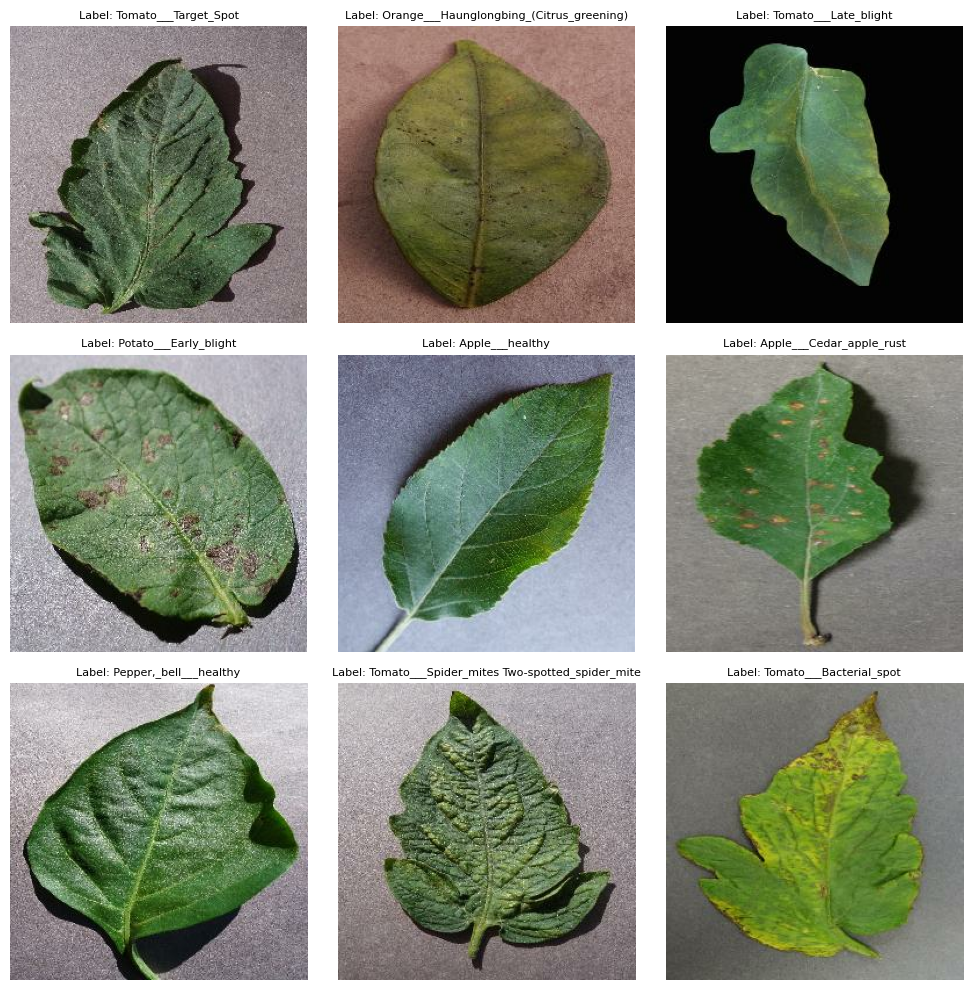

In [5]:
# Show example images with label names
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(all_data.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[label.numpy()]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess data
def format_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32
train_batches = (train_data.map(format_image)
                 .shuffle(1000)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))
val_batches = (val_data.map(format_image)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE))
test_batches = (test_data.map(format_image)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))

3. Construcción del Modelo con Transfer Learning

Utilizamos un modelo preentrenado (por ejemplo, EfficientNetB0) y añadimos capas personalizadas para adaptarlo a nuestro conjunto de datos.

In [7]:
# Load pretrained model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
# Build model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [9]:
# Define the callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [10]:
# Compile the model (assuming 'model' is already defined)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# Train the model with the callbacks
history = model.fit(
    train_batches,
    epochs=50,
    validation_data=val_batches,
    callbacks=[early_stop, model_checkpoint, reduce_lr]
)

Epoch 1/50
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7172 - loss: 1.0448
Epoch 1: val_loss improved from inf to 0.21582, saving model to best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 119s 83ms/step - accuracy: 0.7173 - loss: 1.0445 - val_accuracy: 0.9310 - val_loss: 0.2158 - learning_rate: 0.0010
Epoch 2/50
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8974 - loss: 0.3154
Epoch 2: val_loss improved from 0.21582 to 0.18548, saving model to best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 68s 57ms/step - accuracy: 0.8975 - loss: 0.3154 - val_accuracy: 0.9392 - val_loss: 0.1855 - learning_rate: 0.0010
Epoch 3/50
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9121 - loss: 0.2620
Epoch 3: val_loss improved from 0.18548 to 0.15629, saving model to best_model.keras
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 87s 72ms/step - accuracy: 0.9121 - loss: 0.2620 - val_accuracy: 0.9465 - val_loss: 0.1563 - learning_rate: 0.0010
Epoch 4/50
1187/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 3

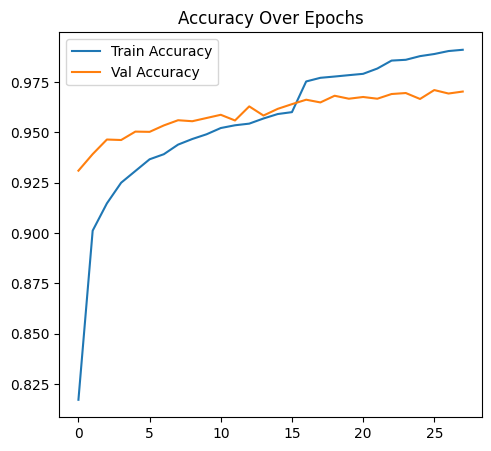

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

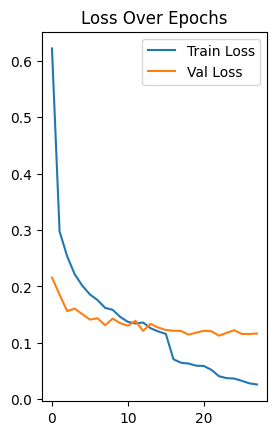

In [13]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

In [14]:
# Evaluate on test set
y_true = []
y_pred = []

for images, labels in test_batches:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━

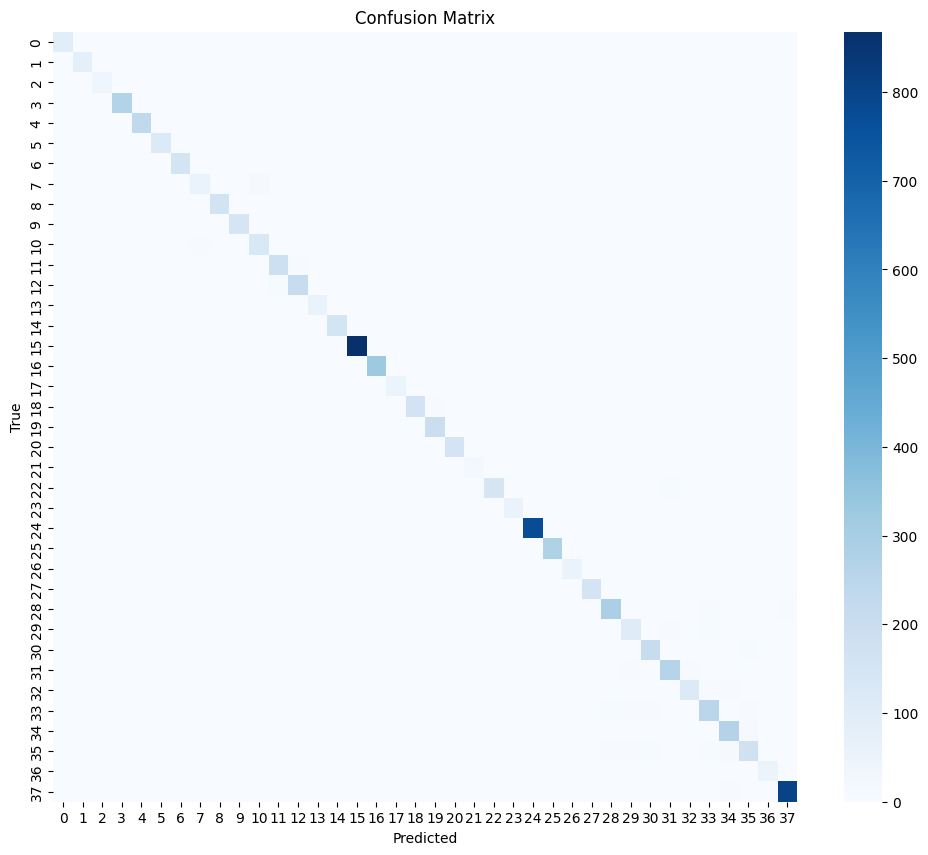

In [15]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
# Classification report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.93      0.96       103
           1       1.00      0.99      0.99        85
           2       0.95      0.95      0.95        40
           3       0.98      0.99      0.99       270
           4       0.99      1.00      1.00       231
           5       1.00      0.99      1.00       123
           6       0.99      0.99      0.99       159
           7       0.90      0.83      0.86        72
           8       0.99      0.98      0.99       166
           9       1.00      1.00      1.00       148
          10       0.90      0.95      0.92       136
          11       0.96      0.97      0.96       192
          12       0.98      0.97      0.97       214
          13       1.00      0.98      0.99        56
          14       0.99      1.00      1.00       159
          15       1.00      1.00      1.00       869
          16       1.00      1.00      1.00       328
          17       0.98    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


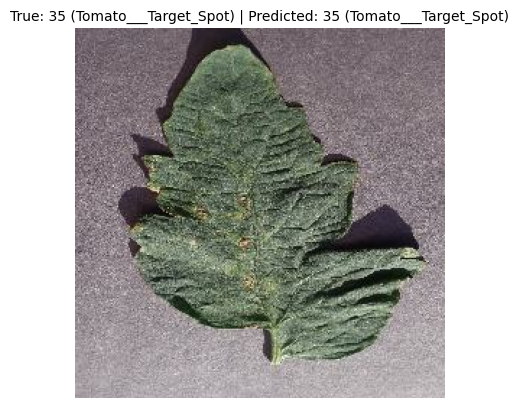

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


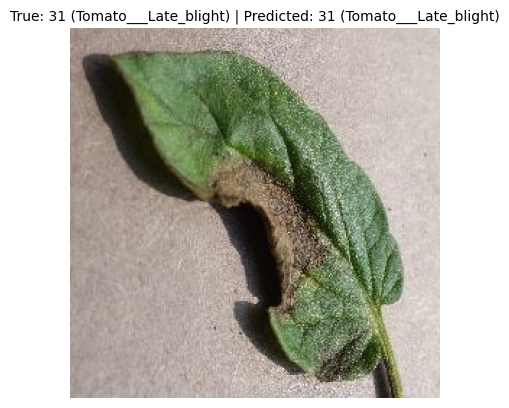

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


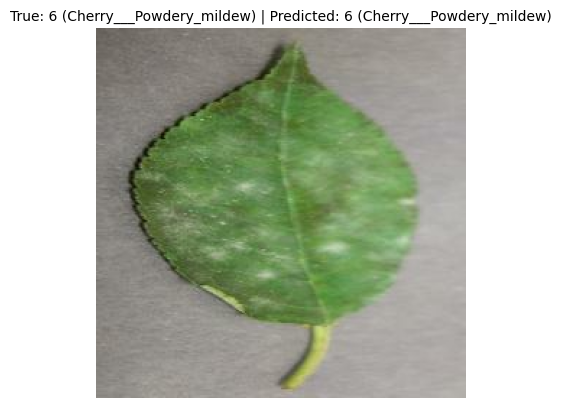

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


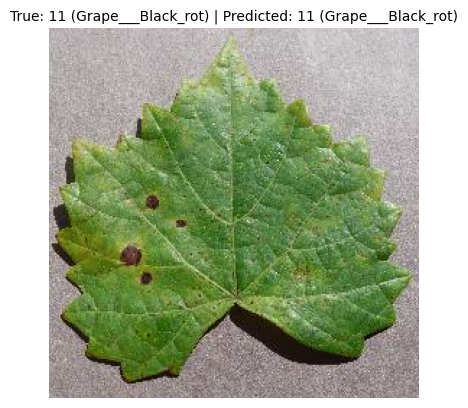

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


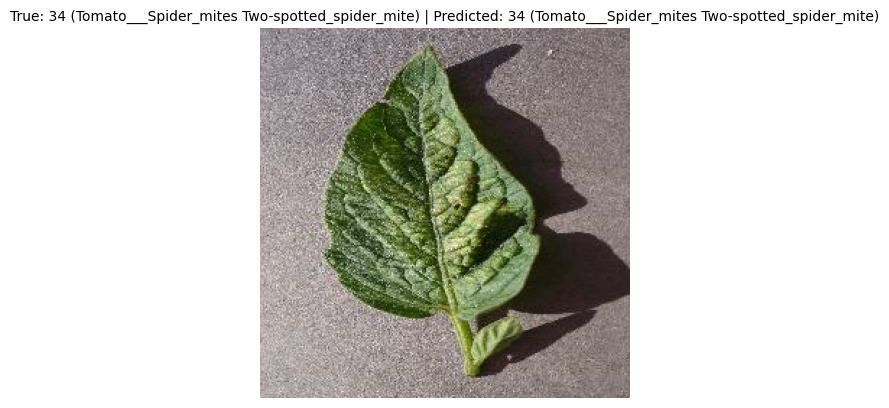

In [20]:
# Predict on random test images with label names
for image, label in test_data.shuffle(1000).take(5):
    img_resized = tf.image.resize(image, (224, 224)) / 255.0
    pred = model.predict(tf.expand_dims(img_resized, axis=0))
    predicted_label = np.argmax(pred)
    plt.imshow(image)
    plt.title(f"True: {label.numpy()} ({class_names[label.numpy()]}) | Predicted: {predicted_label} ({class_names[predicted_label]})", fontsize=10)
    plt.axis('off')
    plt.show()

In [22]:
# Save model
model.save('plant_leaves_classifier_expert.keras')
